In [1]:
# import dependancies
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

###  create training data using chat GPT 3.5 

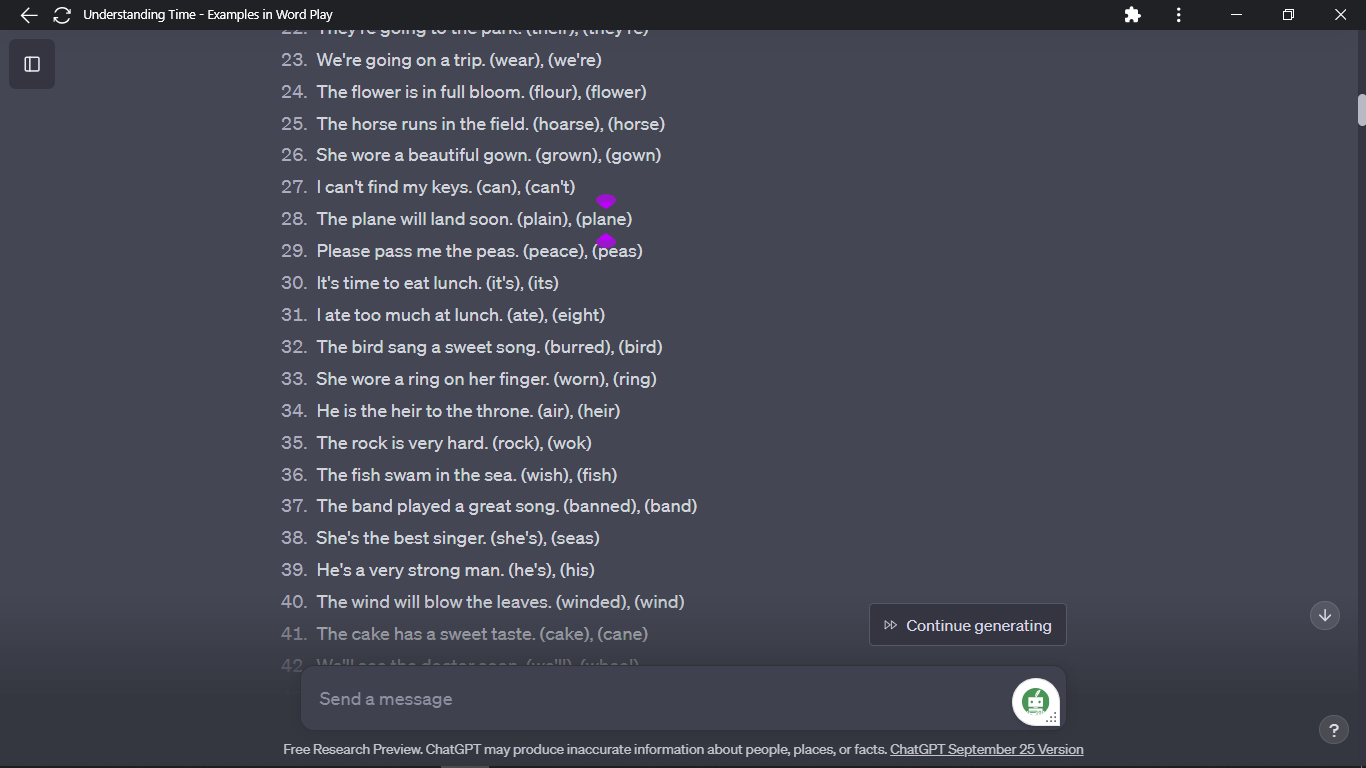

### create dataframe from text data frame

In [2]:
file_path = r'2 test data 500 correct sentences.txt'
with open(file_path, 'r') as f:
    lines = f.readlines()

In [3]:
correct_sentences=[]
mis_pro_word=[]
actual_word=[]
dict_from_text=dict()
for line in lines:
    correct_sentences.append(line.split('.')[1])
    mis_pro_word.append(line.split('.')[2].replace('\n','').replace('(','').replace(')','').split(',')[0])
    actual_word.append(line.split('.')[2].replace('\n','').replace('(','').replace(')','').split(',')[-1])
    dict_from_text['correct_sentences']=correct_sentences
    dict_from_text['mis_pro_word']=mis_pro_word
    dict_from_text['actual_word']=actual_word

text_df=pd.DataFrame(dict_from_text)
text_df

,correct_sentences,mis_pro_word,actual_word
0,The bear was grazing in the meadow,bare,bear
1,The blue sky was dotted with clouds,blew,blue
2,The boar charged at the hunters,bore,boar
3,The bow was strung and ready to fire,bough,bow
4,The class was canceled due to bad weather,clause,class
...,...,...,...
486,The knight is very brave,night,knight
487,The sailboat glided smoothly,sale,sail
488,The bear is a powerful animal,bare,bear
489,The cake is chocolate-flavored,cake,cane


### feature engineering 

In [4]:
# text cleaning for each column 
text_df['actual_word']=text_df['actual_word'].apply(lambda x:x.strip(' '))
text_df['mis_pro_word']=text_df['mis_pro_word'].apply(lambda x:x.strip(' '))
text_df['correct_sentences']=text_df['correct_sentences'].apply(lambda x:x.strip(' '))
text_df.head()

,correct_sentences,mis_pro_word,actual_word
0,The bear was grazing in the meadow,bare,bear
1,The blue sky was dotted with clouds,blew,blue
2,The boar charged at the hunters,bore,boar
3,The bow was strung and ready to fire,bough,bow
4,The class was canceled due to bad weather,clause,class


In [5]:
# remove duplicate rows
text_df.drop_duplicates(inplace=True)
text_df.to_csv('text_df.csv')
text_df.head()

,correct_sentences,mis_pro_word,actual_word
0,The bear was grazing in the meadow,bare,bear
1,The blue sky was dotted with clouds,blew,blue
2,The boar charged at the hunters,bore,boar
3,The bow was strung and ready to fire,bough,bow
4,The class was canceled due to bad weather,clause,class


In [6]:
# remove same records in actual_word and mis_pro_words
text_df_1 = text_df.loc[text_df['mis_pro_word']!=text_df['actual_word']]
text_df_1.head()

,correct_sentences,mis_pro_word,actual_word
0,The bear was grazing in the meadow,bare,bear
1,The blue sky was dotted with clouds,blew,blue
2,The boar charged at the hunters,bore,boar
3,The bow was strung and ready to fire,bough,bow
4,The class was canceled due to bad weather,clause,class


In [8]:
# create "incorrect sentences" to predict "mis_pro_word"
text_df_1['correct_sentences'] = text_df_1.apply(lambda row: row['correct_sentences'].replace(row['actual_word'], row['mis_pro_word']), axis=1)
text_df_1.head()

,correct_sentences,mis_pro_word,actual_word
0,The bare was grazing in the meadow,bare,bear
1,The blew sky was dotted with clouds,blew,blue
2,The bore charged at the hunters,bore,boar
3,The bough was strung and ready to fire,bough,bow
4,The clause was canceled due to bad weather,clause,class


In [9]:
text_df_1.shape

(206, 3)

In [53]:
# create random testing data from dataframe
x=text_df_1['correct_sentences']
y=text_df_1['mis_pro_word']
x_train, x_test , y_train, y_test =train_test_split(x,y,random_state=101,test_size=0.1)

In [54]:
# Tokenize correct_sentences and create sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
X = tokenizer.texts_to_sequences(x_train)
X = pad_sequences(X, padding='post')
X

array([[ 33,  53,   1, ...,   0,   0,   0],
       [  1,  54,   4, ...,  76,   0,   0],
       [ 12,  15,   3, ...,   0,   0,   0],
       ...,
       [  1,  72,   2, ...,   0,   0,   0],
       [  1, 125,  11, ...,   1, 330,   0],
       [  1,   9,   2, ...,  98,   0,   0]])

In [55]:
# Tokenize 'mis_pro_word' labels
y = tokenizer.texts_to_sequences(y_train)
y = pad_sequences(y, padding='post', maxlen=X.shape[1])
y

array([[ 33,   0,   0, ...,   0,   0,   0],
       [ 54,   0,   0, ...,   0,   0,   0],
       [ 20,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [125,   0,   0, ...,   0,   0,   0],
       [  9,   0,   0, ...,   0,   0,   0]])

In [56]:
# Define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

331

In [57]:
# create artificial neural network model
model = Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=X.shape[1]))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation='softmax')))

In [58]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 128)            42368     
                                                                 
 bidirectional_1 (Bidirecti  (None, 8, 256)            263168    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 8, 331)            85067     
 stributed)                                                      
                                                                 
Total params: 390603 (1.49 MB)
Trainable params: 390603 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# fit model
model.fit(X, np.expand_dims(y, -1), batch_size=1, epochs=10, validation_split=0.02)

Epoch 1/10
181/181 [==============================] - 6s 15ms/step - loss: 1.2447 - accuracy: 0.8819 - val_loss: 0.3325 - val_accuracy: 0.9375
Epoch 2/10
181/181 [==============================] - 2s 10ms/step - loss: 0.5100 - accuracy: 0.8867 - val_loss: 0.3396 - val_accuracy: 0.9375
Epoch 3/10
181/181 [==============================] - 2s 11ms/step - loss: 0.4698 - accuracy: 0.8874 - val_loss: 0.3454 - val_accuracy: 0.9062
Epoch 4/10
181/181 [==============================] - 2s 11ms/step - loss: 0.4385 - accuracy: 0.8902 - val_loss: 0.3275 - val_accuracy: 0.9375
Epoch 5/10
181/181 [==============================] - 2s 12ms/step - loss: 0.4100 - accuracy: 0.8971 - val_loss: 0.3501 - val_accuracy: 0.9375
Epoch 6/10
181/181 [==============================] - 2s 12ms/step - loss: 0.3843 - accuracy: 0.9019 - val_loss: 0.3434 - val_accuracy: 0.9375
Epoch 7/10
181/181 [==============================] - 2s 11ms/step - loss: 0.3564 - accuracy: 0.9068 - val_loss: 0.3128 - val_accuracy: 0.9375

In [60]:
# Prepare a sentence for prediction
input_sentence = "The bore charged at the hunters"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
input_sequence = pad_sequences(input_sequence, padding='post', maxlen=X.shape[1])
input_sequence

array([[  1, 142, 143,  19,   1, 144,   0,   0]])

In [61]:
# create word prediction function
def word_pred_from_sentence(sentence):
    input_sequence = tokenizer.texts_to_sequences([sentence])
    input_sequence = pad_sequences(input_sequence, padding='post', maxlen=X.shape[1])
    predictions = model.predict(input_sequence)
    word_list=[]
    for count in range(len(predictions[0])):
        arr_deci=[]
        for i in predictions[0][count]:
            num='{:.30f}'.format(i)
            arr_deci.append(num)
        index_val=arr_deci.index(max(arr_deci))
        if index_val!=0:
            word_list.append(tokenizer.index_word[index_val])
                      
    if not word_list:
        return None
                      
    return word_list[np.argmax(word_list)]

word_pred_from_sentence("They're going to the zoo")

1/1 [==============================] - 1s 873ms/step


In [63]:
# perform prediction to get y_pred on y_test
x_test.values
y_pred=[]
for i in x_test.values:
    print(i[0])
    pre=word_pred_from_sentence(i[0])
    y_pred.append(pre)
    print(i[0])
    print(pre)

She found a tier in her book
1/1 [==============================] - 0s 42ms/step
worn
The burred built a nest
1/1 [==============================] - 0s 12ms/step
son
The night fought bravely
1/1 [==============================] - 0s 10ms/step
dear
The dear is quick
1/1 [==============================] - 0s 25ms/step
dear
The bred is fresh
1/1 [==============================] - 0s 27ms/step
bred
The ship will ship away
1/1 [==============================] - 0s 15ms/step
bred
He has a ton of bricks
1/1 [==============================] - 0s 8ms/step
he
The write path leads to success
1/1 [==============================] - 0s 17ms/step
bred
She's the best singer
1/1 [==============================] - 0s 26ms/step
dear
The rock is very hard
1/1 [==============================] - 0s 39ms/step
dear
The bare is a large animal
1/1 [==============================] - 0s 29ms/step
dear
She found a tier in her shirt
1/1 [==============================] - 0s 23ms/step
worn
The wail is a massive crea

In [64]:
# find accuracy
print('accuracy_score=',accuracy_score(y_pred,y_test))
print('precision_score=',precision_score(y_pred,y_test,average='weighted'))
print('recall_score=',recall_score(y_pred,y_test,average='weighted'))

TypeError: '<' not supported between instances of 'str' and 'NoneType'

In [50]:
df=pd.DataFrame([])
df['y_pred']=y_pred
df['y_test']=y_test.values
df

,y_pred,y_test
0,tier,tier
1,burred,burred
2,night,night
3,dear,dear
4,bred,bred
5,ship,ship
6,ton,ton
7,write,write
8,she's,she's
9,rock,rock
